In [1]:
from functools import partial

import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime

from tabulate import tabulate
from timm.models.vision_transformer import Block
from model_mae import MaskedAutoencoder
from utils import MaskEmbed, get_1d_sincos_pos_embed, ActiveEmbed, Utils

eps = 1e-6

In [4]:
path = './data/ETT/'
file = 'ETTh1.csv'

In [5]:
df = pd.read_csv(path+file)

In [6]:
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [8]:
total_rows = len(df)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [11]:
train_end_pt = int(train_ratio*total_rows)
train_df = df[:train_end_pt]

val_end_pt = train_end_pt + int(val_ratio*total_rows)
val_df = df[train_end_pt:val_end_pt]

test_df = df[val_end_pt:]

In [19]:
train_df.shape, val_df.shape, test_df.shape

((10452, 8), (3484, 8), (3484, 8))

In [17]:
train_df.shape[0] + val_df.shape[0] + test_df.shape[0]

17420

In [ ]:
model = torch.load('./pretrain_checkpoints/ett_pretrain_initial/ett_v0.pth', map_location='cpu')

In [9]:
model.rec_len

35

In [48]:
import wandb

# Log in to your W&B account (if not already logged in)
wandb.login()

True

In [54]:
api = wandb.Api()

In [81]:
runs = api.runs("aneog/mae")
list_of_runs = []
for run in runs:
    list_of_runs.append((run.id, run.name))
    print(f"Run ID: {run.id}, Name: {run.name}")

Run ID: 27f0udvk, Name: finetune_finetune_combined_modeled_scratch_2023-11-27_05:49:26.410131
Run ID: 18a5uonl, Name: finetune_finetune_combined_modeled_scratch_2023-11-27_05:13:04.893369
Run ID: 16dammdd, Name: finetune_finetune_combined_modeled_mask_75_2023-11-27_04:36:11.205433
Run ID: 1l3i6ftg, Name: finetune_finetune_combined_modeled_mask_50_2023-11-27_03:59:03.561445
Run ID: 1isbqcq9, Name: finetune_finetune_combined_modeled_mask_25_2023-11-27_03:22:09.750699
Run ID: 2tzwav4y, Name: finetune_finetune_sunapee_modeled_scratch_2023-11-27_03:17:04.971424
Run ID: 1mf5nwt0, Name: finetune_finetune_mendota_modeled_scratch_2023-11-27_03:15:23.898563
Run ID: cd07p9cr, Name: finetune_finetune_sunapee_modeled_scratch_2023-11-27_02:52:55.665575
Run ID: 3l8kcmod, Name: finetune_finetune_mendota_modeled_scratch_2023-11-27_02:51:20.584071
Run ID: 32ibq183, Name: finetune_finetune_combined_modeled_mask_75_2023-11-27_02:49:10.521424
Run ID: 38jyazrx, Name: finetune_finetune_sunapee_modeled_mask_7

In [82]:
date_regex_a = "2023-11-26"
date_regex_b = "2023-11-27"

In [86]:
filtered_runs =  [(runid, name) for runid, name in list_of_runs if date_regex_a in name or date_regex_b in name]

In [87]:
'''
removing last couple of runs: not part of the experiments
'''
exp_runs = filtered_runs[:-2]

In [89]:
len(exp_runs)

56

In [92]:
'''
sorting the list in ascending order
'''
exp_runs = exp_runs[::-1]
exp_runs

[('vcnt2l5x',
  'pretrain_pretrain_fcr_modeled_mask_25_2023-11-26_22:16:11.938447'),
 ('1s91j9v9',
  'pretrain_pretrain_mendota_modeled_mask_25_2023-11-26_22:16:33.338859'),
 ('37cxcgy9',
  'pretrain_pretrain_sunapee_modeled_mask_25_2023-11-26_22:17:04.520963'),
 ('2jsjwd05',
  'pretrain_pretrain_combined_modeled_mask_25_2023-11-26_22:17:40.990136'),
 ('3c4wbm8v',
  'pretrain_pretrain_fcr_modeled_mask_50_2023-11-26_22:27:43.335017'),
 ('3tndxqhf',
  'pretrain_pretrain_mendota_modeled_mask_50_2023-11-26_22:38:56.109041'),
 ('2ozfb8lm',
  'pretrain_pretrain_fcr_modeled_mask_75_2023-11-26_22:39:11.938618'),
 ('1s9epd4m',
  'pretrain_pretrain_sunapee_modeled_mask_50_2023-11-26_22:40:00.535471'),
 ('39drq654',
  'finetune_finetune_fcr_modeled_mask_25_2023-11-26_22:50:37.451629'),
 ('12ztm755',
  'pretrain_pretrain_combined_modeled_mask_50_2023-11-26_22:53:51.663142'),
 ('nwtlsfcm',
  'pretrain_pretrain_mendota_modeled_mask_75_2023-11-26_23:00:58.849179'),
 ('4adk169y',
  'pretrain_pretrain_

In [104]:
summaries = []
features = ['AirTemp_C',
 'Chla_ugL',
 'DIN_ugL',
 'Inflow_cms',
 'LightAttenuation_Kd',
 'SRP_ugL',
 'Shortwave_Wm2',
 'WaterTemp_C']
val_features = ['VAL_'+feat for feat in features] + ['val_rmse']

In [ ]:
'''
using the api, get all the values for the corresponding experiments
'''

In [144]:
pTRAIN=[('Features', 'Pretrain_25', 'Pretrain_50', 'Pretrain_75'), ('_'*len('Features'), '_'*len('Pretrain_25'), '_'*len('Pretrain_50'), '_'*len('Pretrain_75'))]
print(tabulate(pTRAIN))

--------  -----------  -----------  -----------
Features  Pretrain_25  Pretrain_50  Pretrain_75
________  ___________  ___________  ___________
--------  -----------  -----------  -----------


In [138]:
fNT=[('Features', 'Finetune_FrozenEnc_25','Finetune_FrozenEnc_50','Finetune_FrozenEnc_75', 
      'Finetune_NoFrozen_25','Finetune_NoFrozen_50','Finetune_NoFrozen_75', 'Scratch'),
    ('', ('Lookback 14','Lookback 21'), ('Lookback 14','Lookback 21'), ('Lookback 14','Lookback 21'), 'Lookback 14', 'Lookback 14', 'Lookback 14', ('Lookback 14','Lookback 21'))]

In [139]:
print(tabulate(fNT))

--------  ------------------------------  ------------------------------  ------------------------------  --------------------  --------------------  --------------------  ------------------------------
Features  Finetune_FrozenEnc_25           Finetune_FrozenEnc_50           Finetune_FrozenEnc_75           Finetune_NoFrozen_25  Finetune_NoFrozen_50  Finetune_NoFrozen_75  Scratch
          ('Lookback 14', 'Lookback 21')  ('Lookback 14', 'Lookback 21')  ('Lookback 14', 'Lookback 21')  Lookback 14           Lookback 14           Lookback 14           ('Lookback 14', 'Lookback 21')
--------  ------------------------------  ------------------------------  ------------------------------  --------------------  --------------------  --------------------  ------------------------------


In [251]:
'''
all of these runs are in order (sorted wrt time)
'''
fcr_runs = [(runid, name) for runid, name in exp_runs if 'fcr_modeled' in name]
mendota_runs = [(runid, name) for runid, name in exp_runs if 'mendota_modeled' in name]
sunapee_runs = [(runid, name) for runid, name in exp_runs if 'sunapee_modeled' in name]
combined_runs = [(runid, name) for runid, name in exp_runs if 'combined_modeled' in name]

In [264]:
finetune_cols = ['Finetune25_L14', 'Finetune25_L21', 'Finetune50_L14', 'Finetune50_L21', 'Finetune75_L14', 'Finetune75_L21', 'Finetune25_FFT_L14', 
                 'Finetune50_FFT_L14', 'Finetune75_FFT_L14', 'Scratch_L14', 'Scratch_L21']
pretrain_cols = ['Pretrain_25', 'Pretrain_50', 'Pretrain_75']

In [265]:
def highlight_min(s):
    is_min = s == s.min()
    # styles = ['background-color: yellow' if v else '' for v in is_min]
    text_color = ['color: red' if v else '' for v in is_min]
    return text_color

def lake_runs(lake):
    summaries_pretrain = []
    summaries_finetune = []

    for run_id, name in lake:
        run = api.run(f"aneog/mae/{run_id}")

        summary = run.summary
        params = run.config
        # if 'scratch' in name:
        #     print(f"Lookback window = {params['lookback_window']}")
        # elif 'finetune' in name:
        #     if params['freeze_encoder']=='False':
        #         print('ENCODER NOT FROZEN')
        #     print(f"Lookback window = {params['lookback_window']}")

        if 'finetune' in name:
            print(f"Summary for Run {name}:")
            summary_dict = {}
            for key in val_features:
                if key in summary:
                    summary_dict[key] = summary[key]
                else:
                    print(f"Key: {key} not found in the dictionary.")
            summaries_finetune.append(list(summary_dict.values()))

        if 'pretrain' in name:
            print(f"Summary for Run {name}:")
            summary_dict = {}
            for key in val_features:
                if key in summary:
                    summary_dict[key] = summary[key]
                else:
                    print(f"Key: {key} not found in the dictionary.")
            summaries_pretrain.append(list(summary_dict.values()))
            
    finetune_df = pd.DataFrame(summaries_finetune, columns=val_features).transpose()
    finetune_df.columns = finetune_cols
    
    pretrain_df = pd.DataFrame(summaries_pretrain, columns=val_features).transpose()
    pretrain_df.columns = pretrain_cols
    
    return pretrain_df.style.apply(highlight_min, axis=1), finetune_df.style.apply(highlight_min, axis=1)

In [266]:
fcr_pretrain, fcr_finetune = lake_runs(fcr_runs)

Summary for Run pretrain_pretrain_fcr_modeled_mask_25_2023-11-26_22:16:11.938447:
Summary for Run pretrain_pretrain_fcr_modeled_mask_50_2023-11-26_22:27:43.335017:
Summary for Run pretrain_pretrain_fcr_modeled_mask_75_2023-11-26_22:39:11.938618:
Summary for Run finetune_finetune_fcr_modeled_mask_25_2023-11-26_22:50:37.451629:
Summary for Run finetune_finetune_fcr_modeled_mask_25_2023-11-26_23:03:59.392183:
Summary for Run finetune_finetune_fcr_modeled_mask_50_2023-11-26_23:17:43.380610:
Summary for Run finetune_finetune_fcr_modeled_mask_50_2023-11-26_23:31:21.188049:
Summary for Run finetune_finetune_fcr_modeled_mask_75_2023-11-26_23:44:43.037268:
Summary for Run finetune_finetune_fcr_modeled_mask_75_2023-11-26_23:57:56.861835:
Summary for Run finetune_finetune_fcr_modeled_mask_25_2023-11-27_00:11:37.808476:
Summary for Run finetune_finetune_fcr_modeled_mask_50_2023-11-27_00:25:21.802629:
Summary for Run finetune_finetune_fcr_modeled_mask_75_2023-11-27_00:38:47.604037:
Summary for Run 

In [267]:
mendota_pretrain, mendota_finetune = lake_runs(mendota_runs)

Summary for Run pretrain_pretrain_mendota_modeled_mask_25_2023-11-26_22:16:33.338859:
Summary for Run pretrain_pretrain_mendota_modeled_mask_50_2023-11-26_22:38:56.109041:
Summary for Run pretrain_pretrain_mendota_modeled_mask_75_2023-11-26_23:00:58.849179:
Summary for Run finetune_finetune_mendota_modeled_mask_25_2023-11-26_23:22:34.953113:
Summary for Run finetune_finetune_mendota_modeled_mask_25_2023-11-26_23:45:01.936754:
Summary for Run finetune_finetune_mendota_modeled_mask_50_2023-11-27_00:07:39.018459:
Summary for Run finetune_finetune_mendota_modeled_mask_50_2023-11-27_00:29:59.744714:
Summary for Run finetune_finetune_mendota_modeled_mask_75_2023-11-27_00:52:44.933630:
Summary for Run finetune_finetune_mendota_modeled_mask_75_2023-11-27_01:15:12.005930:
Summary for Run finetune_finetune_mendota_modeled_mask_25_2023-11-27_01:38:33.186673:
Summary for Run finetune_finetune_mendota_modeled_mask_50_2023-11-27_02:02:56.462286:
Summary for Run finetune_finetune_mendota_modeled_mask

In [268]:
sunapee_pretrain, sunapee_finetune = lake_runs(sunapee_runs)

Summary for Run pretrain_pretrain_sunapee_modeled_mask_25_2023-11-26_22:17:04.520963:
Summary for Run pretrain_pretrain_sunapee_modeled_mask_50_2023-11-26_22:40:00.535471:
Summary for Run pretrain_pretrain_sunapee_modeled_mask_75_2023-11-26_23:02:03.511449:
Summary for Run finetune_finetune_sunapee_modeled_mask_25_2023-11-26_23:24:42.208909:
Summary for Run finetune_finetune_sunapee_modeled_mask_25_2023-11-26_23:47:39.186392:
Summary for Run finetune_finetune_sunapee_modeled_mask_50_2023-11-27_00:09:43.933716:
Summary for Run finetune_finetune_sunapee_modeled_mask_50_2023-11-27_00:32:32.972110:
Summary for Run finetune_finetune_sunapee_modeled_mask_75_2023-11-27_00:54:35.822728:
Summary for Run finetune_finetune_sunapee_modeled_mask_75_2023-11-27_01:16:46.658474:
Summary for Run finetune_finetune_sunapee_modeled_mask_25_2023-11-27_01:40:11.777415:
Summary for Run finetune_finetune_sunapee_modeled_mask_50_2023-11-27_02:04:45.157127:
Summary for Run finetune_finetune_sunapee_modeled_mask

In [269]:
combined_pretrain, combined_finetune = lake_runs(combined_runs)

Summary for Run pretrain_pretrain_combined_modeled_mask_25_2023-11-26_22:17:40.990136:
Summary for Run pretrain_pretrain_combined_modeled_mask_50_2023-11-26_22:53:51.663142:
Summary for Run pretrain_pretrain_combined_modeled_mask_75_2023-11-26_23:29:03.058196:
Summary for Run finetune_finetune_combined_modeled_mask_25_2023-11-27_00:03:32.020127:
Summary for Run finetune_finetune_combined_modeled_mask_25_2023-11-27_00:36:32.001801:
Summary for Run finetune_finetune_combined_modeled_mask_50_2023-11-27_01:09:50.117572:
Summary for Run finetune_finetune_combined_modeled_mask_50_2023-11-27_01:44:09.220476:
Summary for Run finetune_finetune_combined_modeled_mask_75_2023-11-27_02:16:47.034971:
Summary for Run finetune_finetune_combined_modeled_mask_75_2023-11-27_02:49:10.521424:
Summary for Run finetune_finetune_combined_modeled_mask_25_2023-11-27_03:22:09.750699:
Summary for Run finetune_finetune_combined_modeled_mask_50_2023-11-27_03:59:03.561445:
Summary for Run finetune_finetune_combined_

In [270]:
fcr_pretrain

,Pretrain_25,Pretrain_50,Pretrain_75
VAL_AirTemp_C,1.745998,2.477344,3.182073
VAL_Chla_ugL,0.286614,0.357439,0.581221
VAL_DIN_ugL,5.844358,8.068210,11.600373
VAL_Inflow_cms,0.004299,0.006381,0.010295
VAL_LightAttenuation_Kd,0.010381,0.012596,0.020117
VAL_SRP_ugL,0.323086,0.435506,0.669607
VAL_Shortwave_Wm2,7.045570,9.941235,12.646084
VAL_WaterTemp_C,0.481387,0.581427,0.839880
val_rmse,3.302717,4.619484,6.185768


In [271]:
fcr_finetune

,Finetune25_L14,Finetune25_L21,Finetune50_L14,Finetune50_L21,Finetune75_L14,Finetune75_L21,Finetune25_FFT_L14,Finetune50_FFT_L14,Finetune75_FFT_L14,Scratch_L14,Scratch_L21
VAL_AirTemp_C,4.023590,3.998497,4.209854,4.038844,4.533321,4.808303,4.607942,4.455440,4.504039,4.260805,4.716854
VAL_Chla_ugL,1.411326,1.010830,1.329413,1.165654,1.493878,1.224818,1.341523,1.389667,1.305575,1.923471,1.366580
VAL_DIN_ugL,20.529528,19.183289,21.119965,20.619240,18.480145,19.544933,20.433167,22.412756,21.104849,21.410194,21.926420
VAL_Inflow_cms,0.023613,0.024480,0.025035,0.024649,0.026087,0.027545,0.029577,0.028405,0.026961,0.025732,0.026720
VAL_LightAttenuation_Kd,0.042941,0.034887,0.042243,0.034774,0.045710,0.040247,0.042155,0.043216,0.042078,0.052993,0.034430
VAL_SRP_ugL,1.130805,1.124592,1.283591,1.175835,1.371249,1.178548,1.385156,1.293031,1.414738,1.473845,1.500935
VAL_Shortwave_Wm2,14.605965,14.381846,14.833463,15.263763,15.412003,14.868455,14.821902,14.541824,14.808083,14.807303,14.714450
VAL_WaterTemp_C,1.136405,1.095209,1.147609,1.087805,1.498700,1.632686,1.406149,1.362087,1.544341,1.404145,1.430831
val_rmse,9.052275,8.619106,9.277269,9.208516,8.703141,8.886453,9.111357,9.611896,9.294312,9.378528,9.524319


In [272]:
legend = """
    <p>Legend:</p>
    <ul>
        <li>Window size = 35 days
    </ul>
    <ul>
        <li>Red text: Lowest RMSE value in each row</li>
    </ul>
    <ul>
        <li>Finetune25_L14: 25% Masked Pretrained model finetuned with lookback=14 days
    </ul>
    <ul>
        <li>Finetune75_FFT_L14: 75% Masked Pretrained model fully finetuned (encoder not frozen) with lookback=14 days
    </ul>
    <ul>
        <li>Scratch_LB_14: Model trained from scratch with lookback = 14 days
    </ul>
"""

with open('results_mod.html', 'w') as f:
    f.write('<html><body>')
    f.write(legend)
    f.write('<h2> FCR Pretrain </h2>')
    f.write(fcr_pretrain.render())
    
    f.write('<h2> FCR Downstream </h2>')
    f.write(fcr_finetune.render())
    
    f.write('<h2> Mendota Pretrain </h2>')
    f.write(mendota_pretrain.render())
    
    f.write('<h2> Mendota Downstream </h2>')
    f.write(mendota_finetune.render())
    
    f.write('<h2> Sunapee Pretrain </h2>')
    f.write(sunapee_pretrain.render())
    
    f.write('<h2> Sunapee Downstream </h2>')
    f.write(sunapee_finetune.render())
    
    f.write('<h2> Combined Pretrain </h2>')
    f.write(combined_pretrain.render())
    
    f.write('<h2> Combined Downstream </h2>')
    f.write(combined_finetune.render())
    
    f.write('</body></html>')

/tmp/ipykernel_21389/1076782573.py:24: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f.write(fcr_pretrain.render())
/tmp/ipykernel_21389/1076782573.py:27: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f.write(fcr_finetune.render())
/tmp/ipykernel_21389/1076782573.py:30: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f.write(mendota_pretrain.render())
/tmp/ipykernel_21389/1076782573.py:33: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f.write(mendota_finetune.render())
/tmp/ipykernel_21389/1076782573.py:36: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f.write(sunapee_pretrain.render())
/tmp/ipykernel_21389/1076782573.py:39: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f.write(sunapee_finetune.render())
/tmp/ipykernel_21389/1076782573.py:42: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

In [44]:
preds = torch.rand((32, 35, 8))
gt = torch.rand((32, 35, 8))

In [43]:
((preds-gt)**2).mean()

tensor(0.1681)

In [185]:
noise = torch.tensor(np.random.choice(10, 10, replace=False)+1)
ids_shuffle = torch.argsort(noise, dim=0)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=0)
print("numbers:",noise)
print("sorted ids", ids_shuffle) 
print("ranking", ids_restore)

numbers: tensor([ 2,  8,  5,  9,  1,  4,  7, 10,  6,  3])
sorted ids tensor([4, 0, 9, 5, 2, 8, 6, 1, 3, 7])
ranking tensor([1, 7, 4, 8, 0, 3, 6, 9, 5, 2])


In [3]:
device

device(type='cuda', index=1)

In [4]:
path = "."
filename = "TransferLearningData.csv"
model_dir = "./model/"
log_dir = "./log/"

In [5]:
# Supply the wandb parameters, like project, run name
wandb_project = "mae"
wandb_run = "larger_pt_window_masking_{}_{}".format(str(datetime.datetime.now().date()), str(datetime.datetime.now().time()))
save_code = True

In [6]:
pre_train_window = 35
non_null_ratio = 0.20

'''
learning rate scheduler parameters
'''
max_lr=5e-2
div_factor=100
pct_start=0.05 
anneal_strategy='cos'
final_div_factor=10000.0

In [7]:
filepath = os.path.join(path, filename)
df = pd.read_csv(filepath)

/tmp/ipykernel_22361/1025252231.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [8]:
df

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,21.69000,2.576500,0.001250,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,21.19500,1.132500,0.003451,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,20.29000,1.154821,0.005080,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,23.55500,1.177141,0.003196,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,24.73000,1.199462,0.001073,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70835,TOOK,2022-12-27,buoy,0.5,observed,NaN,-35.39290,-0.740000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70836,TOOK,2022-12-28,buoy,0.5,observed,NaN,-29.69685,0.575000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70837,TOOK,2022-12-29,buoy,0.5,observed,NaN,-22.03290,-0.675000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70838,TOOK,2022-12-30,buoy,0.5,observed,NaN,-13.60220,-0.980000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN


In [9]:
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [10]:
cols_to_exclude_from_features = ["Lake","Site","Depth_m","DataType","ModelRunType"]
features_col = df.columns.difference(cols_to_exclude_from_features)
features_col = [feat for feat in features_col if not 'flag' in feat.lower() and feat!='DateTime']
features_col

['AirTemp_C',
 'Chla_ugL',
 'DIN_ugL',
 'Inflow_cms',
 'LightAttenuation_Kd',
 'SRP_ugL',
 'Shortwave_Wm2',
 'WaterTemp_C']

In [11]:
# df = df.dropna(subset=features_col)
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [12]:
for lake in df.Lake.unique():
    lake_df = df[df['Lake']==lake]
    print(f"Lake {lake} has types = {lake_df.DataType.unique()}")

Lake FCR has types = ['observed' 'modeled']
Lake Mendota has types = ['modeled']
Lake Sunapee has types = ['modeled']
Lake BARC has types = ['observed']
Lake CRAM has types = ['observed']
Lake LIRO has types = ['observed']
Lake PRLA has types = ['observed']
Lake PRPO has types = ['observed']
Lake SUGG has types = ['observed']
Lake TOOK has types = ['observed']


In [13]:
date_col = ['DateTime']
date_col

['DateTime']

In [14]:
df.DateTime = df.DateTime.astype('datetime64[ns]')

In [15]:
# get the observed values
train_df = df.copy(deep=True)

In [16]:
flag_cols = [col for col in train_df.columns if col.startswith('Flag')]

In [17]:
target_col_ind = features_col.index('Chla_ugL')
target_col_ind

1

In [18]:
num_features = len(features_col)
utils = Utils(num_features=num_features,
              inp_cols=features_col, 
              date_col=date_col, 
              window=pre_train_window, 
              flag_cols=flag_cols,
              non_null_ratio=non_null_ratio,
              stride=1)

In [19]:
def windowed_dataset(df, lake, include_target=True):
    L = df.shape[0]
    stride=1
    num_samples = (L - pre_train_window) // stride + 1
        
    dfX = df[features_col]
    flag_cols = df[flag_cols]
        
    X = np.array([]) #np.zeros([num_samples, self.pre_train_window, self.num_features])
    print(f"Lake = {lake}")
    
    for ii in tqdm(np.arange(num_samples)):
        start_x = self.stride * ii
        end_x = start_x + pre_train_window
            
        subset_df = df.iloc[start_x:end_x, :].copy(deep=True)
        subset_dfX = dfX.iloc[start_x:end_x, :].copy(deep=True)
            
            # Set interpolated rows (having atleast one feature interpolated) to NULL
        condition = (subset_df[flag_cols] != 0).any(axis=1)
        subset_dfX.loc[condition] = None
            
        null_inds = subset_dfX[subset_dfX.isnull().any(axis=1)].index
            
            # subset_dfX.loc[null_inds, :] = None
            
        num_nulls = len(null_inds)
            # print(f"num of nulls = {num_nulls} in a subset of shape = {subset_dfX.shape}")
        non_null_frac = (subset_dfX.shape[0] - num_nulls)/subset_dfX.shape[0]
            
            # print(f"non null frac = {non_null_frac}")
            
        if non_null_frac >= non_null_ratio:
            if X.shape[0]==0:
                X = np.expand_dims(subset_dfX, axis=0)
            else:
                toAdd = np.expand_dims(subset_dfX, axis=0)
                X = np.append(X, toAdd, axis=0)
                    
        return X
    
def windowed_dataset_utils(df, include_target=True):
    
    lakes = df.Lake.unique()
    X = np.array([])
    for lake in lakes:
        df_temp = df[df['Lake']==lake].reset_index(drop=True)
        dtypes = df_temp.DataType.unique()
            
        for dtype in dtypes:
            lake_df = df_temp[df_temp['DataType']==dtype].reset_index(drop='true')
            lake_x = windowed_dataset(lake_df, lake + " " + dtype, include_target=include_target)    
            print(f"lake {lake} has shape = {lake_x.shape}")
            if X.shape[0]==0:
                X = lake_x
            else:
                if lake_x.shape[0] == 0:
                    print(f"Dropping it")
                    continue
                X = np.append(X,lake_x, axis=0)
                
    return X

In [20]:
train_set = pd.DataFrame()
val_set = pd.DataFrame()

for lake in train_df.Lake.unique():
    lake_df = train_df[train_df['Lake']==lake].reset_index(drop='true')
    types = lake_df.DataType.unique()
    for dtype in types:
        lake_type_df = lake_df[lake_df['DataType']==dtype].reset_index(drop='true')
        train, val = utils.train_test_split(lake_type_df, split_type=None, split_date=None, split_ratio=0.8)
        train_set = train_set.append(train, ignore_index=True)
        val_set = val_set.append(val, ignore_index=True)

/tmp/ipykernel_22361/3497671915.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(train, ignore_index=True)
/tmp/ipykernel_22361/3497671915.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_set = val_set.append(val, ignore_index=True)


In [21]:
train_set

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,21.69000,2.576500,0.001250,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,21.19500,1.132500,0.003451,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,20.29000,1.154821,0.005080,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,23.55500,1.177141,0.003196,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,24.73000,1.199462,0.001073,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56660,TOOK,2022-03-09,buoy,0.5,observed,NaN,-19.60455,0.375000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
56661,TOOK,2022-03-10,buoy,0.5,observed,NaN,-26.42870,0.405000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
56662,TOOK,2022-03-11,buoy,0.5,observed,NaN,-26.24415,0.305000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
56663,TOOK,2022-03-12,buoy,0.5,observed,NaN,-20.67380,0.060000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN


In [22]:
val_set

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2021-04-26,50,1.6,observed,NaN,13.97500,3.5310,0.044269,12.8890,...,1.209486,14.800,0,0,0,0.0,1.0,1.0,1.0,0.0
1,FCR,2021-04-27,50,1.6,observed,NaN,19.57000,3.0665,0.043321,13.1800,...,1.214286,12.960,0,0,0,0.0,1.0,1.0,1.0,0.0
2,FCR,2021-04-28,50,1.6,observed,NaN,21.98500,3.2845,0.042200,13.4715,...,1.219124,11.475,0,0,0,0.0,1.0,1.0,1.0,0.0
3,FCR,2021-04-29,50,1.6,observed,NaN,22.38500,1.9820,0.040733,13.8755,...,1.224000,10.180,0,0,0,0.0,1.0,1.0,1.0,0.0
4,FCR,2021-04-30,50,1.6,observed,NaN,17.18500,4.2390,0.039120,16.6955,...,1.228916,9.835,0,0,0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14170,TOOK,2022-12-27,buoy,0.5,observed,NaN,-35.39290,-0.7400,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
14171,TOOK,2022-12-28,buoy,0.5,observed,NaN,-29.69685,0.5750,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
14172,TOOK,2022-12-29,buoy,0.5,observed,NaN,-22.03290,-0.6750,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
14173,TOOK,2022-12-30,buoy,0.5,observed,NaN,-13.60220,-0.9800,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN


In [34]:
'''
plot
'''
def plot(df, sample_index, pre_train_window=35):

    # Extract the selected sample from the validation set and mask
    dates = range(len(sample_index)*pre_train_window)#val_set.loc[sample_index[0]:sample_index[-1]+pre_train_window-1,'DateTime'].values
    
    sample_time_series = df[sample_index] # GT
    ts = sample_time_series[0]
    
    for i in range(1, len(sample_index)):
        ts = torch.cat((ts, sample_time_series[i]), dim=0)
        
    ts = ts.cpu().numpy()                          
    
    # Create a figure
    plt.figure(figsize=(20, 6))
    
    plt.plot(dates, ts[:, target_col_ind], label='Actual TS', marker='o', linestyle='-', markersize=4, color='red')


    plt.title('Actual Time-Series')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.show()

In [279]:
np.random.choice(10, 5) + 100

array([103, 102, 108, 105, 101])

In [230]:
# predictions = torch.randn(32, 35, 8)

pred_list = [torch.randn(32, 35, 8), torch.randn(32, 35, 8), torch.randn(28, 35, 8)]
pred_list = torch.cat(pred_list, dim=0)

In [253]:
pred = torch.rand(100, 35, 8)*100
gt = torch.rand(100, 35, 8)*100

rmse1 = (((pred-gt)**2).mean())**0.5
rmse2 = ((((pred-gt)**2).mean(dim=(-2, -1)))**0.5).mean()
print(rmse1)
print(rmse2)

tensor(40.7673)
tensor(40.7423)


In [307]:
tensor = torch.tensor([[1, 2, 3], [4, 5, 6]])
tensor

tensor([[1, 2, 3],
        [4, 5, 6]])

In [309]:
tensor.shape

torch.Size([2, 3])

In [308]:
tensor.transpose(0, 1)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [310]:
tensor.reshape(tensor.shape[1], tensor.shape[0])

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [311]:
tensor.view(tensor.shape[1], tensor.shape[0])

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [312]:
tensor.permute(1, 0)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [345]:
import pickle
import json

with open("./data/window_dataset_35", 'rb') as pickle_file:
    lake2windows = pickle.load(pickle_file)

In [346]:
lake2windows.keys()

dict_keys(['FCR_observed', 'FCR_modeled', 'Mendota_modeled', 'Sunapee_modeled', 'BARC_observed', 'CRAM_observed', 'LIRO_observed', 'PRLA_observed', 'PRPO_observed', 'SUGG_observed', 'TOOK_observed'])

In [347]:
with open('./config.json', 'r') as json_file:
    config = json.load(json_file)

In [367]:
train_X=[]
for ind, lake in enumerate(config['train_lakes']):
    lake_arr = lake2windows[lake]
    if len(lake_arr)==0:
        continue
    print(lake)
    
    lake_frac = config['train_fractions'][ind]
    num_samples = lake_arr.shape[0]

    end_index = int(num_samples * lake_frac)  # Ending index for the train fraction
    print(lake_arr[:end_index, :, :].shape)
    train_X.append(lake_arr[:end_index, :, :])

FCR_modeled
(1401, 35, 8)
Sunapee_modeled
(17077, 35, 8)
Mendota_modeled
(17077, 35, 8)


In [368]:
1401+17077*2

35555

In [366]:
np.concatenate(train_X, axis=0).shape

(35555, 35, 8)

In [351]:
np.array(train_X).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [332]:
lake2windows['FCR_modeled'].shape

(2336, 35, 8)

In [328]:
arr = np.array([])
for i in range(3):
    temp = np.random.randint(1, 10, (32, 35, 8))
    arr = np.append(arr, temp, axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 3 dimension(s)

In [327]:
arr.shape

(9,)

In [320]:
x[:, 1, 0]

tensor([0.8121, 0.4375, 0.7807])

In [232]:
predictions = torch.randn(32, 35, 8)
predictions.transpose(1,2).shape

torch.Size([32, 8, 35])

In [223]:
predictions = torch.randint(1, 10, (32, 35, 8))
gt = torch.randint(1, 10, (32, 35, 8))
mask = torch.ones((32, 35))

In [224]:
gt.shape, predictions.shape

(torch.Size([32, 35, 8]), torch.Size([32, 35, 8]))

In [225]:
mask.shape

torch.Size([32, 35])

In [226]:
mask.unsqueeze(-1).repeat(1,1,predictions.shape[2]).shape

torch.Size([32, 35, 8])

In [227]:
((predictions-gt)**2).float().mean()

tensor(13.0063)

In [228]:
(((predictions-gt)**2)*mask.unsqueeze(dim=2)).sum()/mask.repeat(1,1, predictions.shape[2]).sum()

tensor(13.0063)

In [288]:
L, N = 10, 5
noise = torch.linspace(0, 1, L).repeat(N, 1)  # noise in [0, 1]

# sort noise for each sample
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)

In [290]:
ids_restore

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [296]:
masks = torch.tensor([0, 0, 1, 1, 1])
tensor = torch.randn(5)

In [306]:
np.floor(np.linspace(14, 35, 4))

array([14., 21., 28., 35.])

In [295]:
np.arange(1, 5+1, 1)

array([1, 2, 3, 4])

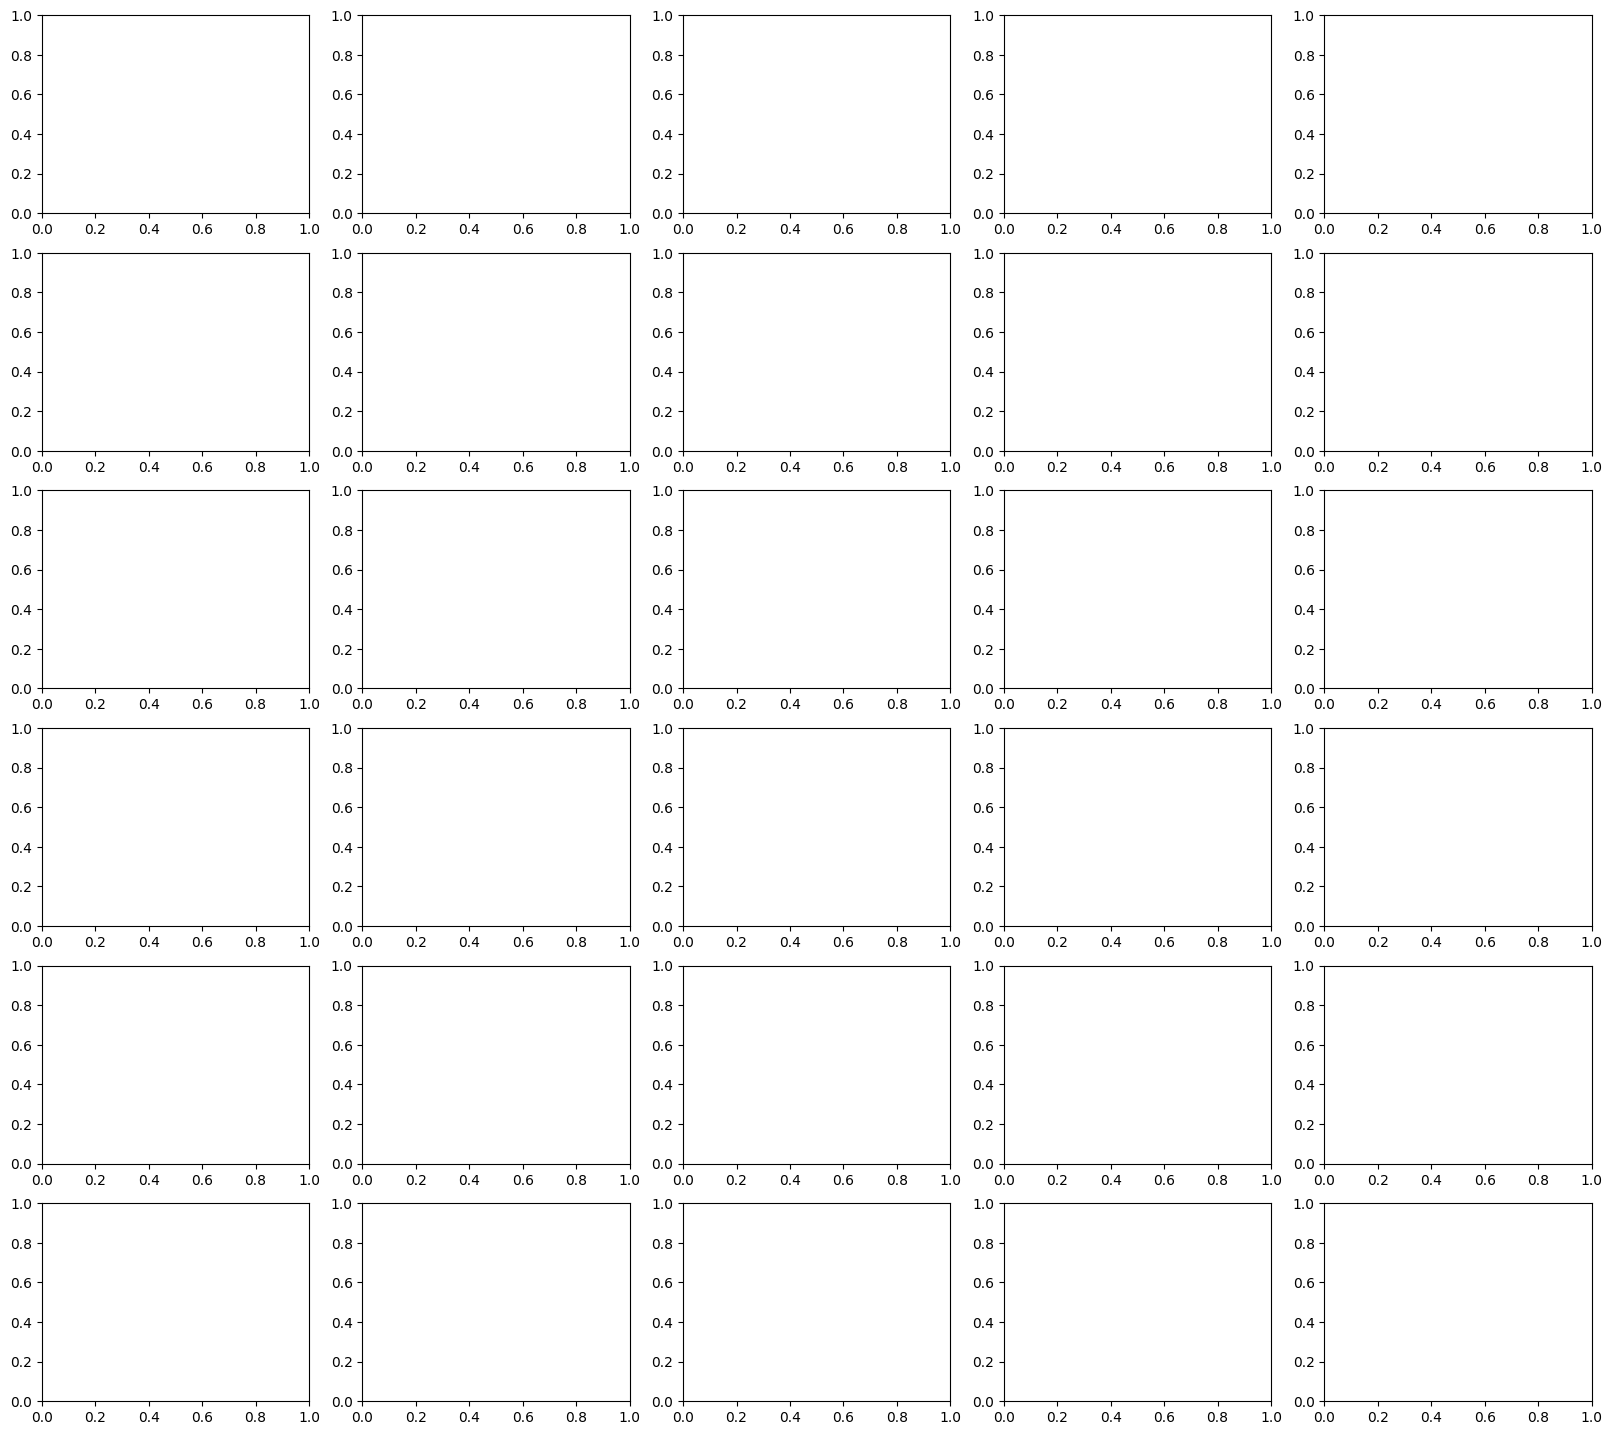

In [291]:
num_samples = 5
num_feats = 6
fig, axes = plt.subplots(num_feats, num_samples, figsize=(4*num_samples, num_feats*3))
        
for sample_id in range(num_samples):
    for idx in range(num_feats):
        ax = axes[idx, sample_id]    

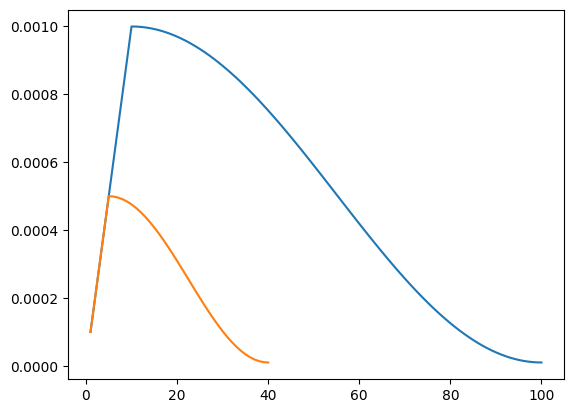

In [264]:
def adjust_learning_rate(epoch):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr = base_lr * epoch / warmup_epochs 
    else:
        lr = min_lr + (base_lr - min_lr) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    return lr

epochs = 100
warmup_epochs = 10
base_lr = 1e-3
min_lr = 1e-5

np_epoch = np.arange(1, epochs+1, 1)
np_lr = np.array([adjust_learning_rate(i) for i in np_epoch])


epochs = 40
warmup_epochs = 5
base_lr = 5e-4
min_lr = 1e-5

np_epoch2 = np.arange(1, epochs+1, 1)
np_lr2 = np.array([adjust_learning_rate(i) for i in np_epoch2])

import matplotlib.pyplot as plt

plt.plot(np_epoch, np_lr)
plt.plot(np_epoch2, np_lr2)
plt.show()

In [267]:
df = pd.DataFrame([[1,2,3], [1,2,2]])
df.std()

0    0.000000
1    0.000000
2    0.707107
dtype: float64

In [273]:
train_tensor = torch.randn(100, 35, 8)
mean = train_tensor.mean(dim=(0, 1))[None, None, :]
std = train_tensor.std(dim=(0, 1))[None, None, :]
print(mean, std)
print(mean.shape, std.shape)

tensor([[[ 0.0234, -0.0051, -0.0095,  0.0130, -0.0084, -0.0008,  0.0148,
           0.0009]]]) tensor([[[1.0031, 1.0119, 1.0117, 1.0036, 1.0321, 1.0133, 1.0084, 1.0045]]])
torch.Size([1, 1, 8]) torch.Size([1, 1, 8])


In [274]:
dim = len(train_tensor.shape)


3

In [262]:
np_lr[5]

0.0006000000000000001

In [197]:
np_lr[-1]

1e-05

In [24]:
load=False

In [25]:
if load:
    train_X = torch.load('unnorm_train_35.pth')
    val_X = torch.load('unnorm_val_35.pth')
else:
    train_X = utils.windowed_dataset_utils(train_set)
    val_X = utils.windowed_dataset_utils(val_set)
    torch.save(train_X, 'unnorm_train_35.pth')
    torch.save(val_X, 'unnorm_val_35.pth')

Lake = FCR observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 965/965 [00:02<00:00, 432.79it/s]


lake FCR has shape = (0,)
Lake = FCR modeled


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1862/1862 [00:04<00:00, 392.44it/s]


lake FCR has shape = (1862, 35, 8)
Lake = Mendota modeled


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22763/22763 [04:20<00:00, 87.34it/s]


lake Mendota has shape = (22763, 35, 8)
Lake = Sunapee modeled


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22763/22763 [03:45<00:00, 100.74it/s]


lake Sunapee has shape = (22763, 35, 8)
Lake = BARC observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 609.51it/s]


lake BARC has shape = (0,)
Dropping it
Lake = CRAM observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 613.79it/s]


lake CRAM has shape = (0,)
Dropping it
Lake = LIRO observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:02<00:00, 467.30it/s]


lake LIRO has shape = (0,)
Dropping it
Lake = PRLA observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:02<00:00, 447.06it/s]


lake PRLA has shape = (0,)
Dropping it
Lake = PRPO observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:02<00:00, 450.39it/s]


lake PRPO has shape = (0,)
Dropping it
Lake = SUGG observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:02<00:00, 450.82it/s]


lake SUGG has shape = (0,)
Dropping it
Lake = TOOK observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:02<00:00, 451.01it/s]


lake TOOK has shape = (0,)
Dropping it
Lake = FCR observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 452.83it/s]


lake FCR has shape = (0,)
Lake = FCR modeled


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 434.92it/s]


lake FCR has shape = (440, 35, 8)
Lake = Mendota modeled


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5666/5666 [00:17<00:00, 322.10it/s]


lake Mendota has shape = (5666, 35, 8)
Lake = Sunapee modeled


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5666/5666 [00:17<00:00, 322.71it/s]


lake Sunapee has shape = (5666, 35, 8)
Lake = BARC observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 443.88it/s]


lake BARC has shape = (0,)
Dropping it
Lake = CRAM observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 443.20it/s]


lake CRAM has shape = (0,)
Dropping it
Lake = LIRO observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 436.74it/s]


lake LIRO has shape = (0,)
Dropping it
Lake = PRLA observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 441.02it/s]


lake PRLA has shape = (0,)
Dropping it
Lake = PRPO observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 443.66it/s]


lake PRPO has shape = (0,)
Dropping it
Lake = SUGG observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 442.41it/s]


lake SUGG has shape = (0,)
Dropping it
Lake = TOOK observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 442.05it/s]


lake TOOK has shape = (0,)
Dropping it


In [28]:
if not load:
    train_X = torch.from_numpy(train_X).type(torch.Tensor)
    val_X = torch.from_numpy(val_X).type(torch.Tensor)

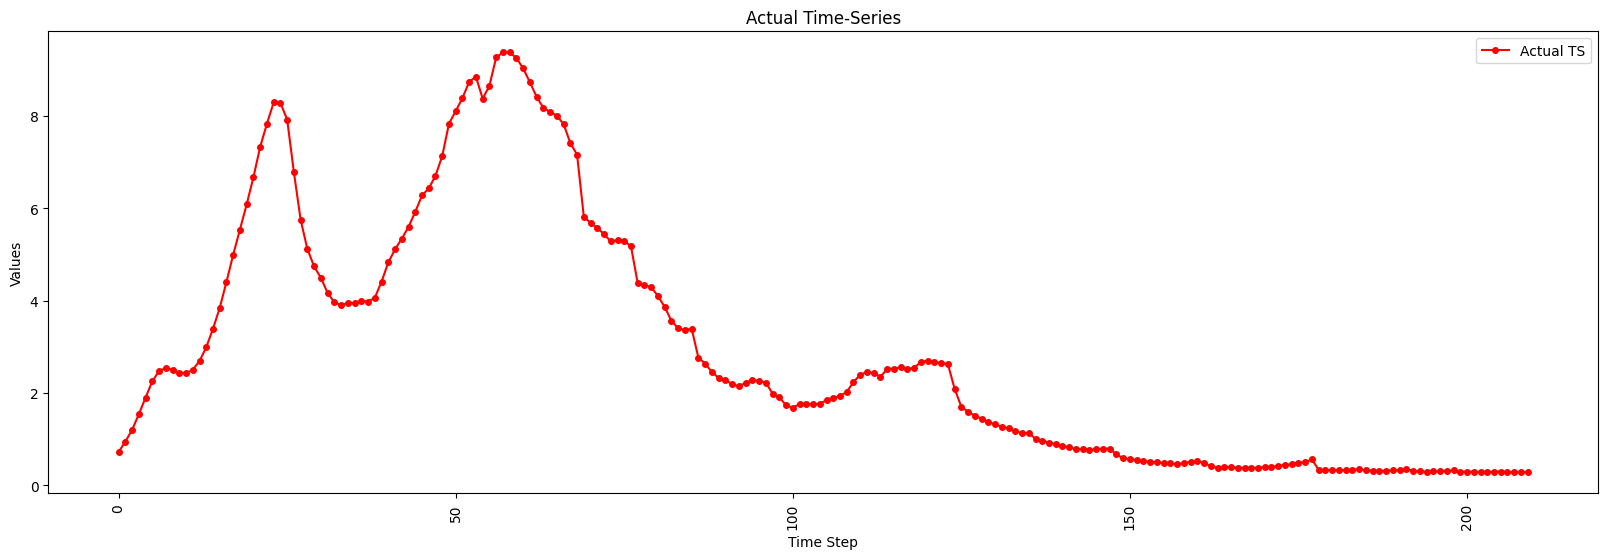

In [35]:
'''
Plot un-normalized
'''
sample_index=[0, 35, 70, 105, 140, 175]
plot(train_X, sample_index)

<AxesSubplot: >

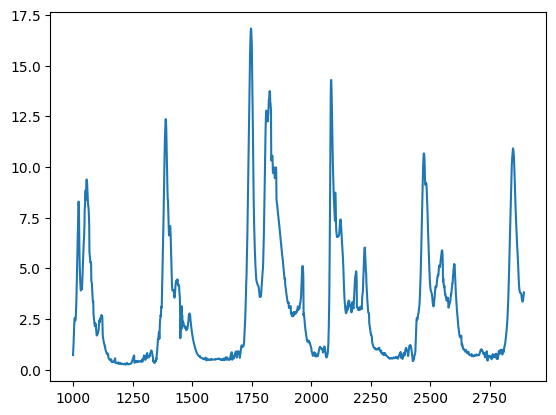

In [44]:
lakefcr = train_set[train_set['Lake']=='FCR'].reset_index()
lakefcr[lakefcr['DataType']=='modeled']['Chla_ugL'].plot()

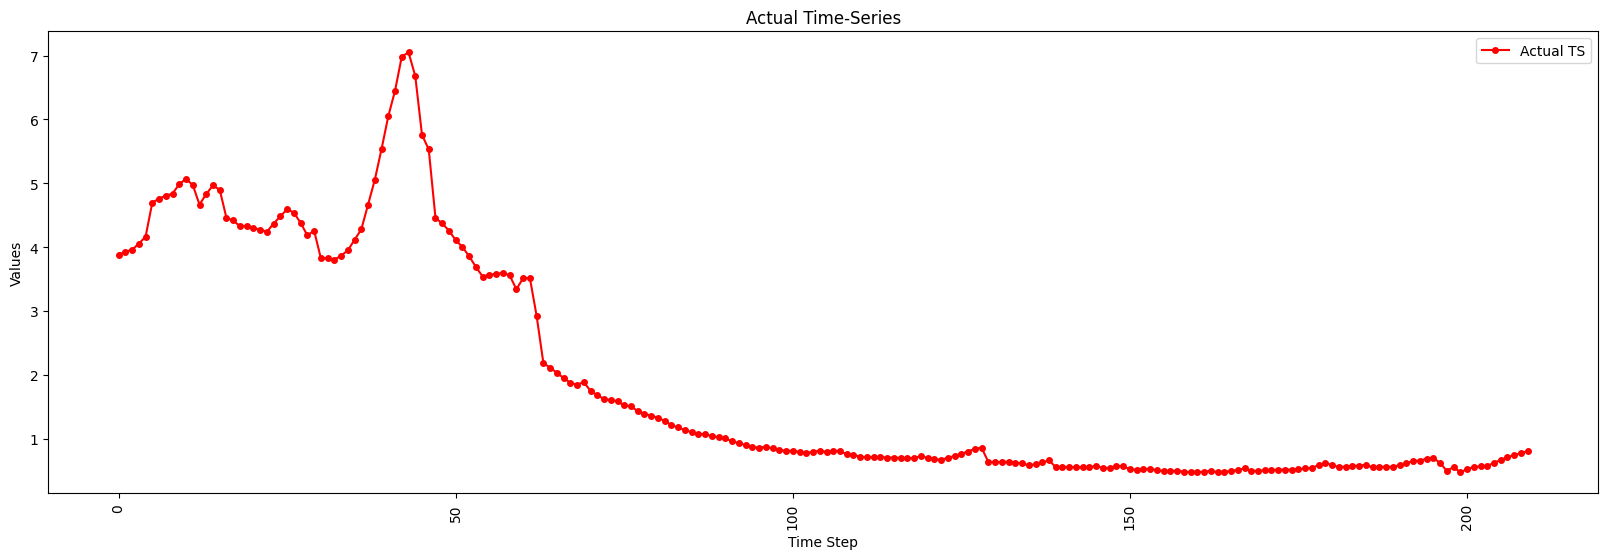

In [36]:
'''
Plot un-normalized
'''

plot(val_X, sample_index)

<AxesSubplot: >

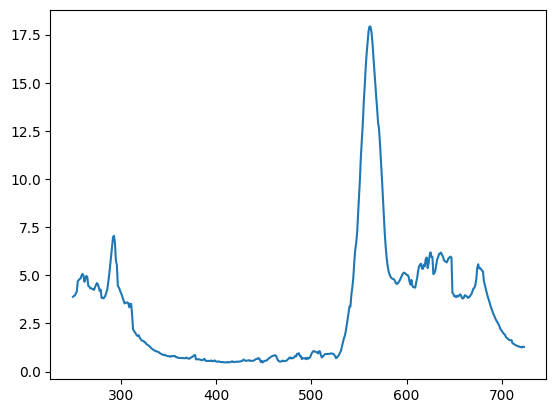

In [43]:
lakefcr = val_set[val_set['Lake']=='FCR'].reset_index()
lakefcr[lakefcr['DataType']=='modeled']['Chla_ugL'].plot()

### Normalize

In [45]:
train_set = utils.normalize(train_set)

In [46]:
val_set = utils.normalize(val_set, use_stat=True)

In [47]:
if load:
    train_X = torch.load('norm_train_35.pth')
    val_X = torch.load('norm_val_35.pth')
else:
    train_X = utils.windowed_dataset_utils(train_set)
    val_X = utils.windowed_dataset_utils(val_set)
    torch.save(train_X, 'norm_train_35.pth')
    torch.save(val_X, 'norm_val_35.pth')

Lake = FCR observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 965/965 [00:02<00:00, 444.60it/s]


lake FCR has shape = (0,)
Lake = FCR modeled


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1862/1862 [00:04<00:00, 400.08it/s]


lake FCR has shape = (1862, 35, 8)
Lake = Mendota modeled


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22763/22763 [03:50<00:00, 98.78it/s]


lake Mendota has shape = (22763, 35, 8)
Lake = Sunapee modeled


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22763/22763 [03:38<00:00, 104.05it/s]


lake Sunapee has shape = (22763, 35, 8)
Lake = BARC observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 607.58it/s]


lake BARC has shape = (0,)
Dropping it
Lake = CRAM observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 611.40it/s]


lake CRAM has shape = (0,)
Dropping it
Lake = LIRO observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 609.57it/s]


lake LIRO has shape = (0,)
Dropping it
Lake = PRLA observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 611.19it/s]


lake PRLA has shape = (0,)
Dropping it
Lake = PRPO observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 609.68it/s]


lake PRPO has shape = (0,)
Dropping it
Lake = SUGG observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 604.16it/s]


lake SUGG has shape = (0,)
Dropping it
Lake = TOOK observed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 611.88it/s]


lake TOOK has shape = (0,)
Dropping it
Lake = FCR observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 607.91it/s]


lake FCR has shape = (0,)
Lake = FCR modeled


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 581.32it/s]


lake FCR has shape = (440, 35, 8)
Lake = Mendota modeled


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5666/5666 [00:13<00:00, 427.80it/s]


lake Mendota has shape = (5666, 35, 8)
Lake = Sunapee modeled


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5666/5666 [00:13<00:00, 435.25it/s]


lake Sunapee has shape = (5666, 35, 8)
Lake = BARC observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 602.46it/s]


lake BARC has shape = (0,)
Dropping it
Lake = CRAM observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 606.66it/s]


lake CRAM has shape = (0,)
Dropping it
Lake = LIRO observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 606.68it/s]


lake LIRO has shape = (0,)
Dropping it
Lake = PRLA observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 610.66it/s]


lake PRLA has shape = (0,)
Dropping it
Lake = PRPO observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 602.98it/s]


lake PRPO has shape = (0,)
Dropping it
Lake = SUGG observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 601.47it/s]


lake SUGG has shape = (0,)
Dropping it
Lake = TOOK observed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 607.26it/s]


lake TOOK has shape = (0,)
Dropping it


In [49]:
if not load:
    train_X = torch.from_numpy(train_X).type(torch.Tensor)
    val_X = torch.from_numpy(val_X).type(torch.Tensor)

In [52]:
val_X = val_X*utils.feat_std + utils.feat_mean
train_X = train_X*utils.feat_std + utils.feat_mean

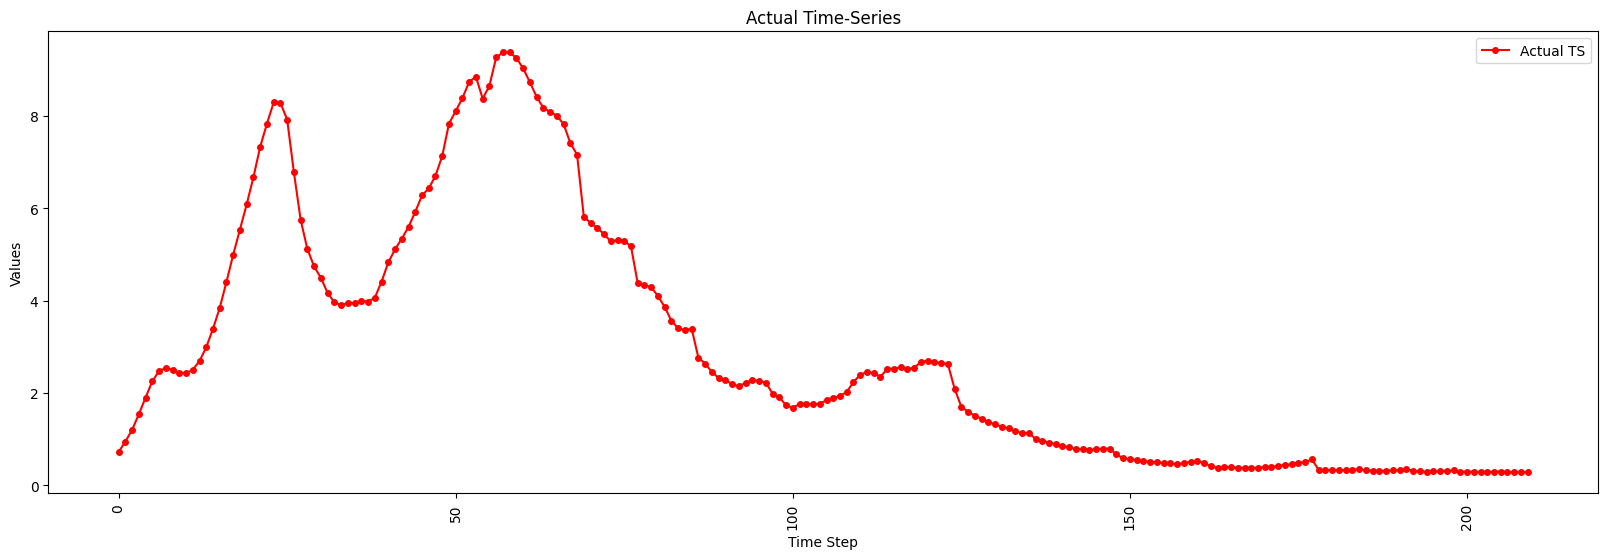

In [53]:
'''
Plot after un-normalized
'''
sample_index=[0, 35, 70, 105, 140, 175]
plot(train_X, sample_index)

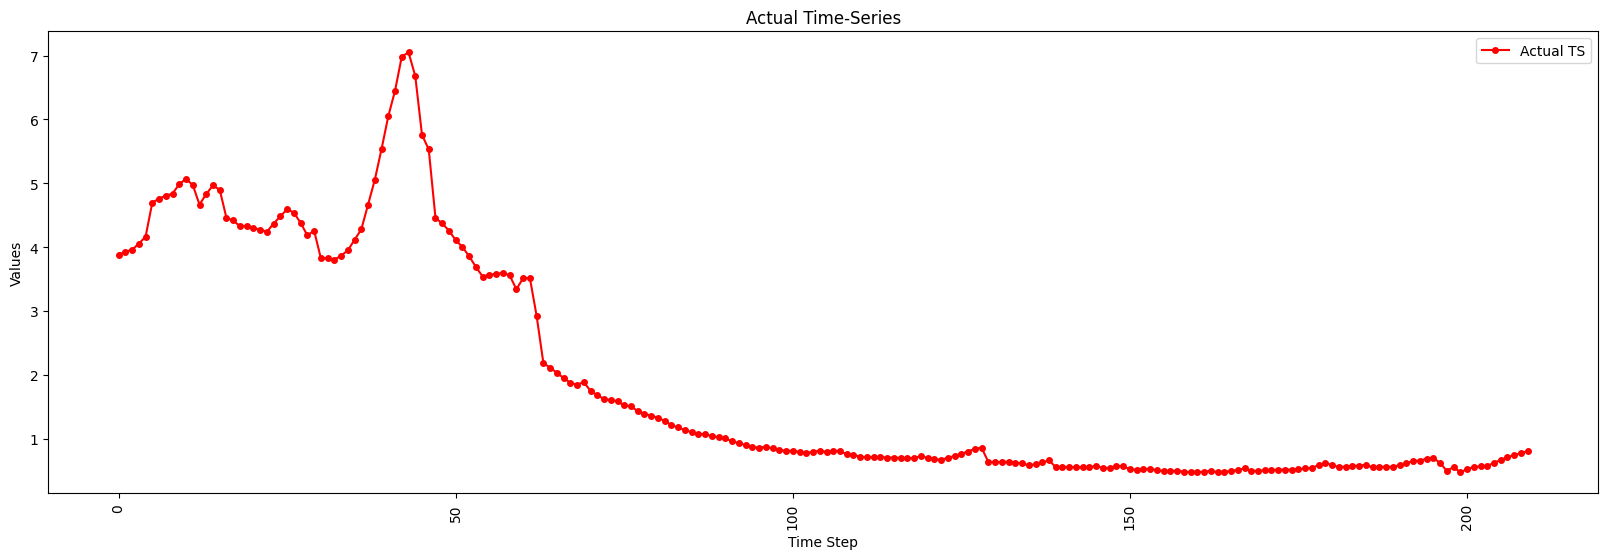

In [54]:

plot(val_X, sample_index)

In [58]:
'''
check for < 0 chlorophyll values - before and after normalizing
'''
torch.all(val_X[:, :, 1]>0)

tensor(True)

In [59]:
'''
check for < 0 chlorophyll values - before and after normalizing
'''
torch.all(train_X[:, :, 1]>0)

tensor(True)

In [60]:
trainX = torch.load('norm_train_35.pth')
valX = torch.load('norm_val_35.pth')

In [64]:
model = torch.load('masked_penal_model.pth')

In [71]:
trainX = torch.from_numpy(trainX).type(torch.Tensor)
valX = torch.from_numpy(valX).type(torch.Tensor)

In [72]:
model_args = {
    'num_feats':num_features,
    'rec_len': pre_train_window,
    'embed_dim': 64,
    'depth': 2,
    'num_heads': 4,
    'decoder_embed_dim':32,
    'decoder_depth':2,
    'decoder_num_heads':4,
    'mlp_ratio':4,
    'norm_layer':partial(nn.LayerNorm, eps=eps),
    'mask_ratio':0.5
}
train_args = {
    'batch_size':32,
    'accum_iter':1,
    'min_lr':1e-5,
    'weight_decay':0.05,
    'lr': None,
    'blr': 1e-2,
    'warmup_epochs':10, #40
    'max_epochs': 10, #600
    'device':device,
    'project_name': wandb_project,
    'run_name': wandb_run,
    'save_code': save_code,
    'eval_freq':2,
    'target_col_ind':target_col_ind,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor
}

In [76]:
valX = valX.reshape(valX.shape[0], valX.shape[2], valX.shape[1])
trainX = trainX.reshape(trainX.shape[0], trainX.shape[2], trainX.shape[1])

In [75]:
metrics_val, masks_val = model.predict(valX, train_args)

368it [00:02, 129.15it/s]


In [77]:
metrics_train, masks_train = model.predict(trainX, train_args)

1481it [00:11, 126.54it/s]


In [78]:
predictions_val=metrics_val['pred'].detach()
predictions_train=metrics_train['pred'].detach()

masks_val = masks_val.detach()
masks_train = masks_train.detach()

In [79]:
predictions_val = predictions_val*utils.feat_std + utils.feat_mean
predictions_train = predictions_train*utils.feat_std + utils.feat_mean

In [80]:
valX = valX*utils.feat_std + utils.feat_mean
trainX = trainX*utils.feat_std + utils.feat_mean

In [82]:
'''
reshape before plotting
'''
valX = valX.reshape(valX.shape[0], valX.shape[2], valX.shape[1])
trainX = trainX.reshape(trainX.shape[0], trainX.shape[2], trainX.shape[1])

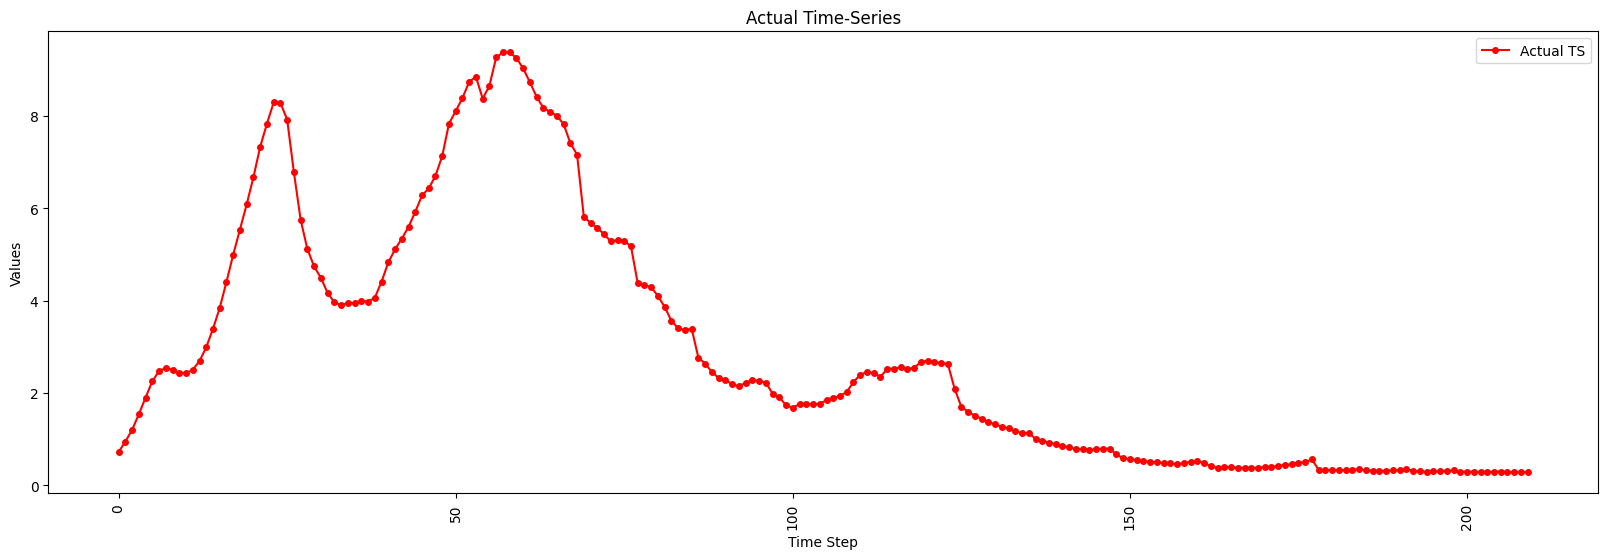

In [83]:
plot(trainX, sample_index)

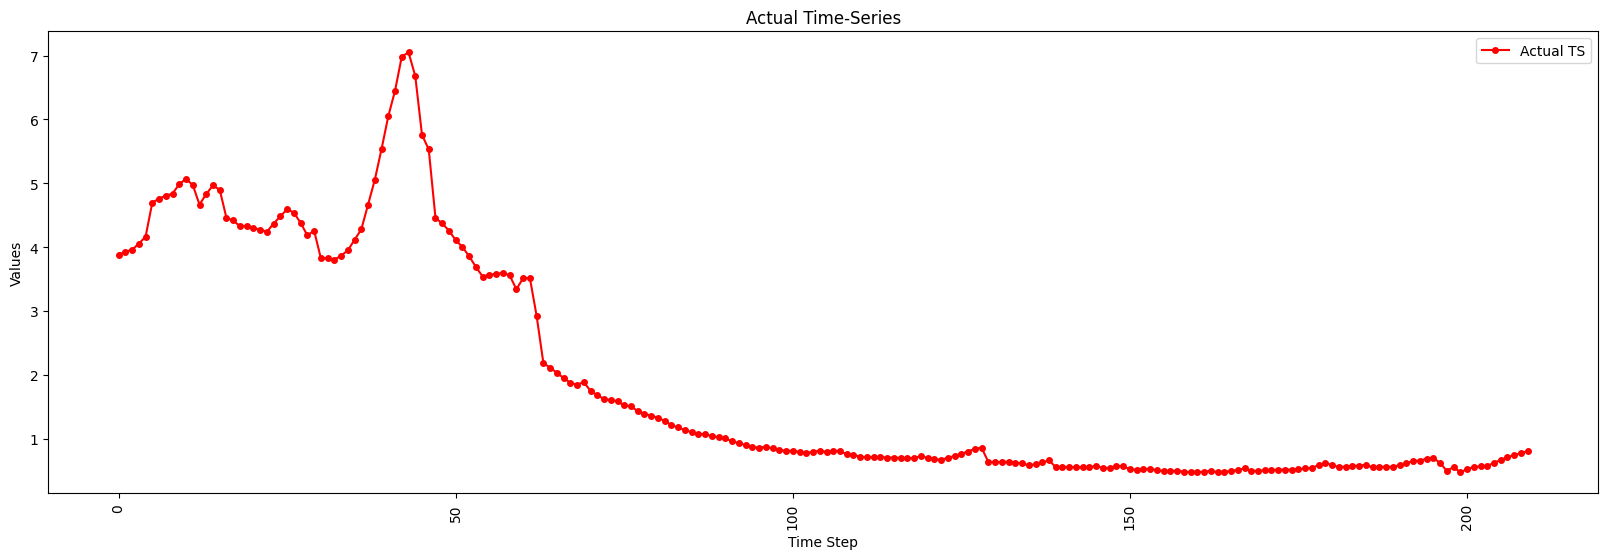

In [84]:
plot(valX, sample_index)

In [86]:
predictions_val.shape

torch.Size([11772, 35, 8])

In [87]:
valX.shape

torch.Size([11772, 35, 8])

In [91]:
masks_val.shape

torch.Size([11772, 35])

In [102]:
masks_val.unsqueeze(2).shape

torch.Size([11772, 35, 1])

In [176]:
'''
plot
'''
def plot_preds(df, preds, masks, sample_index, pre_train_window=35):

    # Extract the selected sample from the validation set and mask
    dates = range(len(sample_index)*pre_train_window)#val_set.loc[sample_index[0]:sample_index[-1]+pre_train_window-1,'DateTime'].values
    
    sample_time_series = df[sample_index].to(device) # GT
    predictions = preds[sample_index].to(device)
    mask = masks[sample_index].to(device)
    
    ts = sample_time_series[0]
    ps = predictions[0]
    ms = mask[0]
    
    for i in range(1, len(sample_index)):
        ts = torch.cat((ts, sample_time_series[i]), dim=0)
        ps = torch.cat((ps, predictions[i]), dim=0)
        ms = torch.cat((ms, mask[i]), dim=0)
    
    masked_ts = ms.unsqueeze(1)*ts
    # unmasked_ts = (1-ms).unsqueeze(1)*ts
    
    masked_ts = torch.where(masked_ts==0, torch.tensor(float('nan')).to(device), masked_ts)
    # unmasked_ts = torch.where(unmasked_ts== 0, torch.tensor(float('nan')).to(device), unmasked_ts)
    
    masked_ts = masked_ts.cpu().numpy()
    # unmasked_ts = unmasked_ts.cpu().numpy()
    
    ts = ts.cpu().numpy()                          
    ps = ps.cpu().numpy()
    ms = ms.cpu().numpy()
    
    # Create a figure
    plt.figure(figsize=(20, 6))
    
    
    

    plt.plot(dates, ps[:, target_col_ind], label='Prediction TS', marker='o', linestyle='-', markersize=4,
            color='green')
    plt.plot(dates, ts[:, target_col_ind], label='Unmasked TS', marker='o', linestyle='-', markersize=4, 
             color='blue')
    plt.plot(dates, masked_ts[:, target_col_ind], label='Masked TS', marker='o', linestyle='-', markersize=8,
             markerfacecolor='red', markeredgecolor='red', linewidth=5, color='red', alpha=0.7)

    plt.title('Masked Time-Series')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.show()

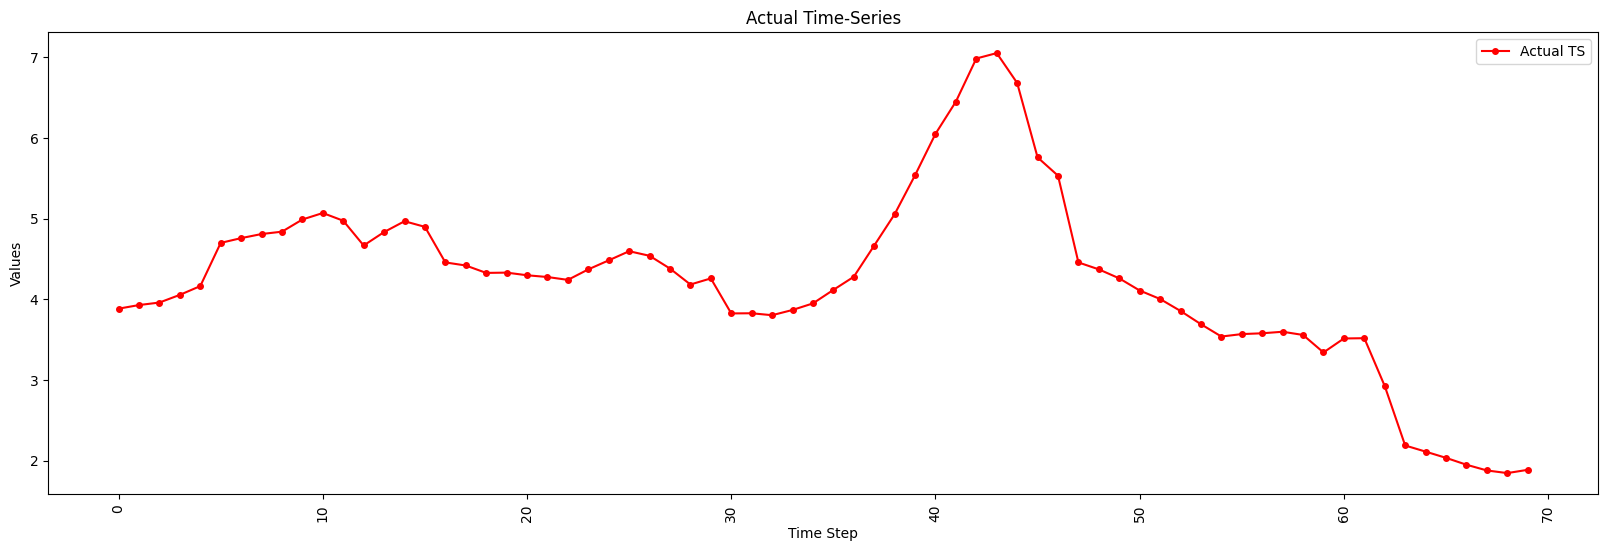

In [144]:
sample_index = [0, 35]
plot(valX, sample_index)

In [178]:
sample_index = [0, 35, 70]

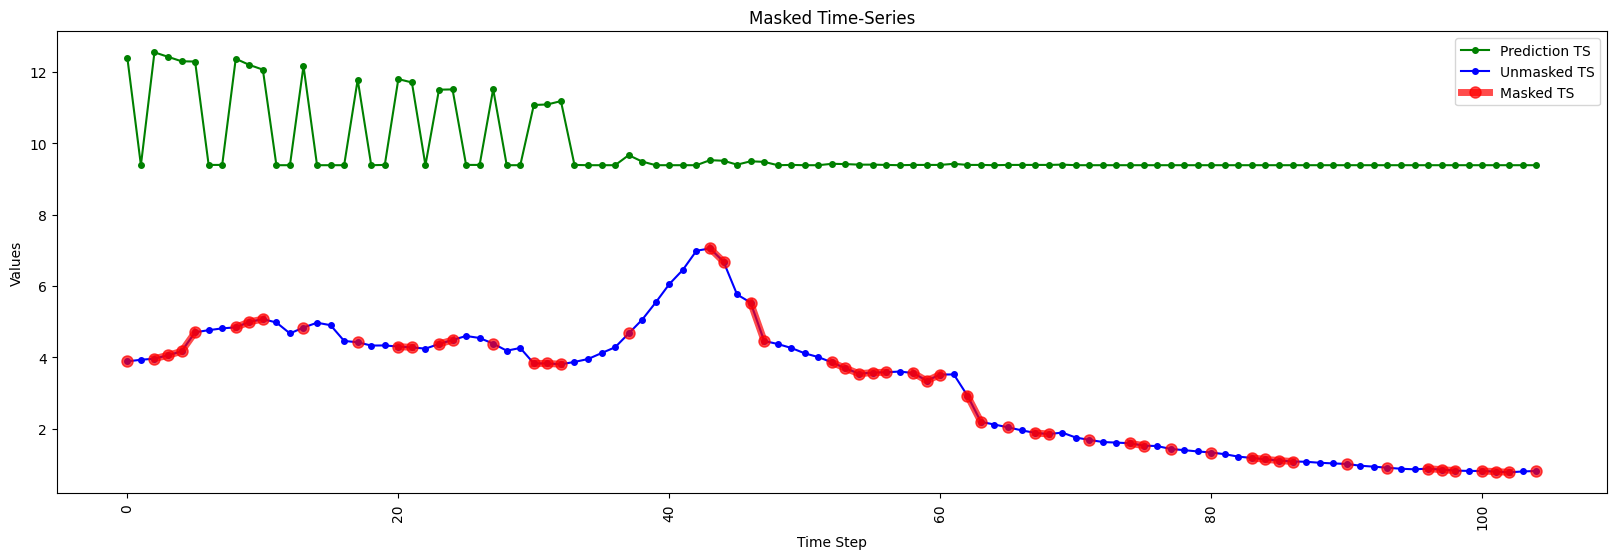

In [179]:
plot_preds(valX, predictions_val, masks_val, sample_index)